In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/list-contents.sh
/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/variants/i3-gen12/ddr4-2133-16g/Conti_03/Conti_03-20240227_21-16-45/ata_read.csv
/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/variants/i3-gen12/ddr4-2133-16g/Conti_03/Conti_03-20240227_21-16-45/ata_write.csv
/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/variants/i3-gen12/ddr4-2133-16g/Conti_03/Conti_03-20240227_21-16-45/mem_exec.csv
/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/variants/i3-gen12/ddr4-2133-16g/Conti_03/Conti_03-20240227_21-16-45/mem_readwrite.csv
/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/variants/i3-gen12/ddr4-2133-16g/Conti_03/Conti_03-20240227_21-16-45/mem_read.csv
/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/variants/i3-gen12/ddr4-2133-16g/Conti_03/Conti_03-20240227_21-

# *1 | Importing Libraries*

In [25]:
import os
import time
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple, Dict, Optional
from concurrent.futures import ThreadPoolExecutor, as_completed

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

import matplotlib.pyplot as plt
from tqdm import tqdm

warnings.filterwarnings('ignore')

# *2 | Configuration*

In [26]:
class Config:
    # Paths
    KAGGLE_DATA_PATH = "/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset"

    # --- Data loading optimizations ---
    MAX_SAMPLES_PER_CLASS = 1000     # Maximum samples per class (limit to 1000)
    MAX_ROWS_PER_FILE = 5000         # Maximum rows per CSV file (limit to 5000)
    NUM_WORKERS_LOAD = 8             # Number of threads for data loading

    # --- Model parameters ---
    INPUT_SIZE = 5                  # timestamp, timestamp_ns, address, size, entropy
    HIDDEN_SIZE = 128
    NUM_LAYERS = 2
    NUM_CLASSES = 2
    DROPOUT = 0.3

    # --- Temporal sequence parameters ---
    SEQUENCE_LENGTH = 256            # Reduced to 256
    STRIDE = 64

    # --- Training parameters ---
    BATCH_SIZE = 256
    EPOCHS = 100                     # Reduced to 100
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-4
    GRADIENT_ACCUMULATION_STEPS = 2
    MAX_TRAINING_TIME = 50 * 60      # 50 minutes

    SEED = 42

    # --- Metadata ---
    RANSOMWARE_KEYWORDS = [
        "cerber", "gandcrab", "globeimposter", "lockbit", "maze",
        "wannacry", "conti", "revil", "darkside", "ryuk"
    ]

    BENIGN_KEYWORDS = [
        "chrome", "firefox", "office", "vlc", "idle", "delete",
        "decrypt", "7zip", "winrar", "notepad", "word", "excel"
    ]


def set_seed(seed=Config.SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# *3| Fast Data Loading*

In [27]:
class FastDataLoader:
    """
    Optimized data loader:
    - Loads only ata_write.csv files
    - Uses multithreading for faster processing
    """

    def __init__(self, base_path: str = Config.KAGGLE_DATA_PATH):
        self.base_path = Path(base_path)

    def _get_label(self, path: str) -> Optional[int]:
        """
        Determine class label from file path.
        Returns:
        1 -> Ransomware
        0 -> Benign
        None -> Unknown
        """
        path = path.lower()

        for kw in Config.RANSOMWARE_KEYWORDS:
            if kw in path:
                return 1

        for kw in Config.BENIGN_KEYWORDS:
            if kw in path:
                return 0

        return None

    def _find_samples(self) -> Tuple[List[Path], List[Path]]:
        """
        Collect and balance ransomware and benign samples
        """
        benign_samples = []
        ransomware_samples = []

        for csv_path in self.base_path.glob("**/ata_write.csv"):
            label = self._get_label(str(csv_path))

            if label == 0:
                benign_samples.append(csv_path)
            elif label == 1:
                ransomware_samples.append(csv_path)

        np.random.shuffle(benign_samples)
        np.random.shuffle(ransomware_samples)

        benign_samples = benign_samples[:Config.MAX_SAMPLES_PER_CLASS]
        ransomware_samples = ransomware_samples[:Config.MAX_SAMPLES_PER_CLASS]

        print(
            f"Samples selected → "
            f"Benign: {len(benign_samples)}, "
            f"Ransomware: {len(ransomware_samples)}"
        )

        return benign_samples, ransomware_samples

    def _load_single_file(
        self, args: Tuple[Path, int]
    ) -> Optional[Tuple[np.ndarray, int]]:
        """
        Load and preprocess a single CSV file
        """
        csv_path, label = args

        try:
            df = pd.read_csv(
                csv_path,
                header=None,
                names=[
                    "timestamp", "timestamp_ns",
                    "address", "size",
                    "entropy", "flag"
                ],
                nrows=Config.MAX_ROWS_PER_FILE
            )

            if len(df) < 50:
                return None

            data = df[
                ["timestamp", "timestamp_ns", "address", "size", "entropy"]
            ].values.astype(np.float32)

            # Normalization
            data[:, 0] -= data[0, 0]          # Relative timestamp
            data[:, 1] = np.log1p(data[:, 1]) # Log timestamp_ns
            data[:, 2] = np.log1p(data[:, 2]) # Log address
            data[:, 3] = np.log1p(data[:, 3]) # Log size

            return data, label

        except Exception:
            return None

    def _create_sequences(
        self, data: np.ndarray, label: int
    ) -> Tuple[List[np.ndarray], List[int]]:
        """
        Convert raw data into fixed-length sequences
        """
        sequences = []
        labels = []

        seq_len = Config.SEQUENCE_LENGTH
        stride = Config.STRIDE

        for start in range(0, len(data) - seq_len + 1, stride):
            sequences.append(data[start:start + seq_len])
            labels.append(label)

        # Padding for short sequences
        if 32 <= len(data) < seq_len:
            padded = np.zeros((seq_len, data.shape[1]), dtype=np.float32)
            padded[:len(data)] = data
            sequences.append(padded)
            labels.append(label)

        return sequences, labels

    def load_dataset(self) -> Tuple[List[np.ndarray], List[int]]:
        """
        Load entire dataset using multithreading
        """
        print("Starting optimized dataset loading...")
        start_time = time.time()

        # Step 1: Collect files
        benign_files, ransomware_files = self._find_samples()
        all_files = (
            [(f, 0) for f in benign_files] +
            [(f, 1) for f in ransomware_files]
        )

        # Step 2: Parallel file loading
        print(
            f"Loading {len(all_files)} files using "
            f"{Config.NUM_WORKERS_LOAD} threads..."
        )

        loaded_data = []
        with ThreadPoolExecutor(
            max_workers=Config.NUM_WORKERS_LOAD
        ) as executor:
            futures = [
                executor.submit(self._load_single_file, args)
                for args in all_files
            ]

            for future in tqdm(
                as_completed(futures),
                total=len(futures),
                desc="Loading files"
            ):
                result = future.result()
                if result is not None:
                    loaded_data.append(result)

        # Step 3: Create sequences
        print("Creating sequences...")
        all_sequences = []
        all_labels = []

        for data, label in loaded_data:
            seqs, labs = self._create_sequences(data, label)
            all_sequences.extend(seqs)
            all_labels.extend(labs)

        load_time = time.time() - start_time

        benign_count = sum(1 for l in all_labels if l == 0)
        ransomware_count = sum(1 for l in all_labels if l == 1)

        print(f"Dataset loaded in {load_time:.1f} seconds")
        print(f"Total sequences: {len(all_sequences)}")
        print(f"Benign: {benign_count}, Ransomware: {ransomware_count}")

        return all_sequences, all_labels


# *4 | PyTorch Dataset*

In [28]:
class RansomwareDataset(Dataset):
    def __init__(
        self,
        sequences: List[np.ndarray],
        labels: List[int],
        scaler: Optional[RobustScaler] = None,
        fit_scaler: bool = False
    ):
        """
        Custom PyTorch Dataset for ransomware detection

        Parameters:
        - sequences: List of input sequences (numpy arrays)
        - labels: Corresponding class labels
        - scaler: Optional RobustScaler for normalization
        - fit_scaler: Whether to fit scaler on the dataset
        """
        self.sequences = sequences
        self.labels = labels

        if fit_scaler:
            # Fit scaler using a subset of sequences for efficiency
            all_data = np.vstack(
                [s.reshape(-1, s.shape[-1]) for s in sequences[:1000]]
            )
            self.scaler = RobustScaler()
            self.scaler.fit(all_data)
        else:
            self.scaler = scaler

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Return one sequence-label pair
        """
        seq = self.sequences[idx].copy()

        if self.scaler is not None:
            seq = self.scaler.transform(
                seq.reshape(-1, seq.shape[-1])
            ).reshape(seq.shape)

        return (
            torch.tensor(seq, dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.long)
        )

# *5 | Model Definition*

In [29]:
class AttentionLayer(nn.Module):
    """
    Temporal attention mechanism
    """

    def __init__(self, hidden_size: int):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        """
        x shape: (batch_size, sequence_length, hidden_size)
        """
        weights = F.softmax(self.attention(x), dim=1)
        attended = torch.sum(weights * x, dim=1)
        return attended, weights


class RansomwareDetector(nn.Module):
    """
    BiLSTM + Attention based ransomware detection model
    """

    def __init__(self):
        super().__init__()

        # Input projection layer
        self.input_proj = nn.Sequential(
            nn.Linear(Config.INPUT_SIZE, Config.HIDDEN_SIZE),
            nn.LayerNorm(Config.HIDDEN_SIZE),
            nn.ReLU(),
            nn.Dropout(Config.DROPOUT)
        )

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=Config.HIDDEN_SIZE,
            hidden_size=Config.HIDDEN_SIZE,
            num_layers=Config.NUM_LAYERS,
            batch_first=True,
            bidirectional=True,
            dropout=Config.DROPOUT if Config.NUM_LAYERS > 1 else 0
        )

        # Attention layer
        self.attention = AttentionLayer(Config.HIDDEN_SIZE * 2)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(Config.HIDDEN_SIZE * 2, Config.HIDDEN_SIZE),
            nn.LayerNorm(Config.HIDDEN_SIZE),
            nn.ReLU(),
            nn.Dropout(Config.DROPOUT),
            nn.Linear(Config.HIDDEN_SIZE, Config.NUM_CLASSES)
        )

    def forward(self, x):
        """
        Forward pass
        """
        x = self.input_proj(x)
        x, _ = self.lstm(x)
        x, attn_weights = self.attention(x)
        logits = self.classifier(x)
        return logits, attn_weights


class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance
    """

    def __init__(self, alpha: float = 0.25, gamma: float = 2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        """
        Compute focal loss
        """
        ce_loss = F.cross_entropy(inputs, targets, reduction="none")
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()


# *6 | Trainer*

In [30]:
class Trainer:
    def __init__(self, model, device, num_gpus: int = 1):
        self.device = device
        self.use_amp = torch.cuda.is_available()

        # Multi-GPU support
        if num_gpus > 1:
            model = nn.DataParallel(model)

        self.model = model.to(device)

        # Loss, optimizer, scaler
        self.criterion = FocalLoss()
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=Config.LEARNING_RATE,
            weight_decay=Config.WEIGHT_DECAY
        )

        self.scaler = GradScaler() if self.use_amp else None

        # Tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.val_accs = []

        self.best_loss = float("inf")
        self.best_state = None

    def _train_epoch(self, loader, scheduler):
        """
        Train model for one epoch
        """
        self.model.train()
        total_loss = 0.0
        self.optimizer.zero_grad()

        for i, (seqs, labels) in enumerate(loader):
            seqs = seqs.to(self.device)
            labels = labels.to(self.device)

            if self.use_amp:
                with autocast():
                    logits, _ = self.model(seqs)
                    loss = (
                        self.criterion(logits, labels)
                        / Config.GRADIENT_ACCUMULATION_STEPS
                    )

                self.scaler.scale(loss).backward()

                if (i + 1) % Config.GRADIENT_ACCUMULATION_STEPS == 0:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.optimizer.zero_grad()
                    scheduler.step()
            else:
                logits, _ = self.model(seqs)
                loss = (
                    self.criterion(logits, labels)
                    / Config.GRADIENT_ACCUMULATION_STEPS
                )
                loss.backward()

                if (i + 1) % Config.GRADIENT_ACCUMULATION_STEPS == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    scheduler.step()

            total_loss += loss.item() * Config.GRADIENT_ACCUMULATION_STEPS

        return total_loss / len(loader)

    @torch.no_grad()
    def _validate(self, loader):
        """
        Validate model
        """
        self.model.eval()
        total_loss = 0.0
        preds, labels_all = [], []

        for seqs, labels in loader:
            seqs = seqs.to(self.device)
            labels = labels.to(self.device)

            with autocast() if self.use_amp else torch.no_grad():
                logits, _ = self.model(seqs)
                loss = self.criterion(logits, labels)

            total_loss += loss.item()
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(loader)
        acc = accuracy_score(labels_all, preds)

        return avg_loss, acc

    def train(self, train_loader, val_loader):
        """
        Full training loop
        """
        start_time = time.time()

        total_steps = (
            len(train_loader)
            * Config.EPOCHS
            // Config.GRADIENT_ACCUMULATION_STEPS
        )

        scheduler = OneCycleLR(
            self.optimizer,
            max_lr=Config.LEARNING_RATE,
            total_steps=total_steps
        )

        print(
            f"\nTraining started: {Config.EPOCHS} epochs, "
            f"batch size = {Config.BATCH_SIZE}"
        )

        patience = 5
        patience_count = 0

        for epoch in range(Config.EPOCHS):
            epoch_start = time.time()

            train_loss = self._train_epoch(train_loader, scheduler)
            val_loss, val_acc = self._validate(val_loader)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)

            elapsed = time.time() - start_time

            print(
                f"Epoch [{epoch + 1:02d}/{Config.EPOCHS}] | "
                f"Train Loss: {train_loss:.4f} | "
                f"Val Loss: {val_loss:.4f} | "
                f"Val Acc: {val_acc:.4f} | "
                f"Epoch Time: {time.time() - epoch_start:.1f}s | "
                f"Total Time: {elapsed / 60:.1f}m"
            )

            # Save best model
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.best_state = {
                    k: v.cpu().clone()
                    for k, v in self.model.state_dict().items()
                }
                patience_count = 0
                print("✅ Best model saved")
            else:
                patience_count += 1
                if patience_count >= patience:
                    print("⚠️ Early stopping")
                    break

            # Time limit check
            if elapsed > Config.MAX_TRAINING_TIME:
                print("⚠️ Time limit reached")
                break

        # Load best model
        if self.best_state is not None:
            self.model.load_state_dict(self.best_state)

        return {
            "train_losses": self.train_losses,
            "val_losses": self.val_losses,
            "val_accs": self.val_accs,
            "time": time.time() - start_time
        }

# *7 | Evaluator*

In [31]:
class Evaluator:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    @torch.no_grad()
    def evaluate(self, loader):
        """
        Evaluate model on validation or test data
        """
        self.model.eval()

        preds = []
        labels = []
        probs = []

        for seqs, labs in loader:
            seqs = seqs.to(self.device)

            with autocast() if torch.cuda.is_available() else torch.no_grad():
                logits, _ = self.model(seqs)

            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labels.extend(labs.numpy())
            probs.extend(
                F.softmax(logits, dim=1)[:, 1].cpu().numpy()
            )

        results = {
            "accuracy": accuracy_score(labels, preds),
            "precision": precision_score(labels, preds, zero_division=0),
            "recall": recall_score(labels, preds, zero_division=0),
            "f1": f1_score(labels, preds, zero_division=0),
            "auc_roc": (
                roc_auc_score(labels, probs)
                if len(set(labels)) > 1 else 0
            ),
            "confusion_matrix": confusion_matrix(labels, preds),
            "report": classification_report(
                labels,
                preds,
                target_names=["Benign", "Ransomware"],
                zero_division=0
            )
        }

        return results

    def plot_results(self, train_res, eval_res, path: str = "results.png"):
        """
        Plot training and evaluation results
        """
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Loss curves
        axes[0, 0].plot(train_res["train_losses"], label="Train")
        axes[0, 0].plot(train_res["val_losses"], label="Validation")
        axes[0, 0].set_title("Loss")
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Validation accuracy
        axes[0, 1].plot(train_res["val_accs"], "g-")
        axes[0, 1].set_title("Validation Accuracy")
        axes[0, 1].grid(True)

        # Confusion matrix
        cm = eval_res["confusion_matrix"]
        axes[1, 0].imshow(cm, cmap="Blues")
        axes[1, 0].set_title("Confusion Matrix")

        for i in range(2):
            for j in range(2):
                axes[1, 0].text(
                    j, i, str(cm[i, j]),
                    ha="center", va="center",
                    fontsize=14
                )

        axes[1, 0].set_xticks([0, 1])
        axes[1, 0].set_yticks([0, 1])
        axes[1, 0].set_xticklabels(["Benign", "Ransomware"])
        axes[1, 0].set_yticklabels(["Benign", "Ransomware"])

        # Metrics bar chart
        metrics = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
        values = [
            eval_res["accuracy"],
            eval_res["precision"],
            eval_res["recall"],
            eval_res["f1"],
            eval_res["auc_roc"]
        ]

        bars = axes[1, 1].bar(metrics, values)
        axes[1, 1].set_ylim(0, 1)
        axes[1, 1].set_title("Evaluation Metrics")

        for bar, val in zip(bars, values):
            axes[1, 1].text(
                bar.get_x() + bar.get_width() / 2,
                val + 0.02,
                f"{val:.3f}",
                ha="center"
            )

        plt.tight_layout()
        plt.savefig(path, dpi=150)
        plt.show()

        print(f"📊 Results saved to {path}")


# *8 | Main*

🔐 Ransomware Detection | RanSMAP 2024 | FAST VERSION

🖥️ Device: cuda, GPUs: 1

[1/6] 📥 Loading data...
Starting optimized dataset loading...
Samples selected → Benign: 600, Ransomware: 1000
Loading 1600 files using 8 threads...


Loading files: 100%|██████████| 1600/1600 [00:06<00:00, 244.97it/s]


Creating sequences...
Dataset loaded in 9.6 seconds
Total sequences: 119636
Benign: 44703, Ransomware: 74933

[2/6] ✂️ Splitting data...
✔ Train samples: 95708, Test samples: 23928

[3/6] 📦 Creating datasets...

[4/6] 🧠 Initializing model...
✔ Model parameters: 726,915

[5/6] 🚀 Training...

Training started: 100 epochs, batch size = 256
Epoch [01/100] | Train Loss: 0.0441 | Val Loss: 0.0392 | Val Acc: 0.6347 | Epoch Time: 49.0s | Total Time: 0.8m
✅ Best model saved
Epoch [02/100] | Train Loss: 0.0382 | Val Loss: 0.0361 | Val Acc: 0.6642 | Epoch Time: 49.1s | Total Time: 1.6m
✅ Best model saved
Epoch [03/100] | Train Loss: 0.0359 | Val Loss: 0.0348 | Val Acc: 0.6831 | Epoch Time: 49.0s | Total Time: 2.5m
✅ Best model saved
Epoch [04/100] | Train Loss: 0.0352 | Val Loss: 0.0344 | Val Acc: 0.7038 | Epoch Time: 49.0s | Total Time: 3.3m
✅ Best model saved
Epoch [05/100] | Train Loss: 0.0340 | Val Loss: 0.0325 | Val Acc: 0.7306 | Epoch Time: 49.0s | Total Time: 4.1m
✅ Best model saved
Epoch 

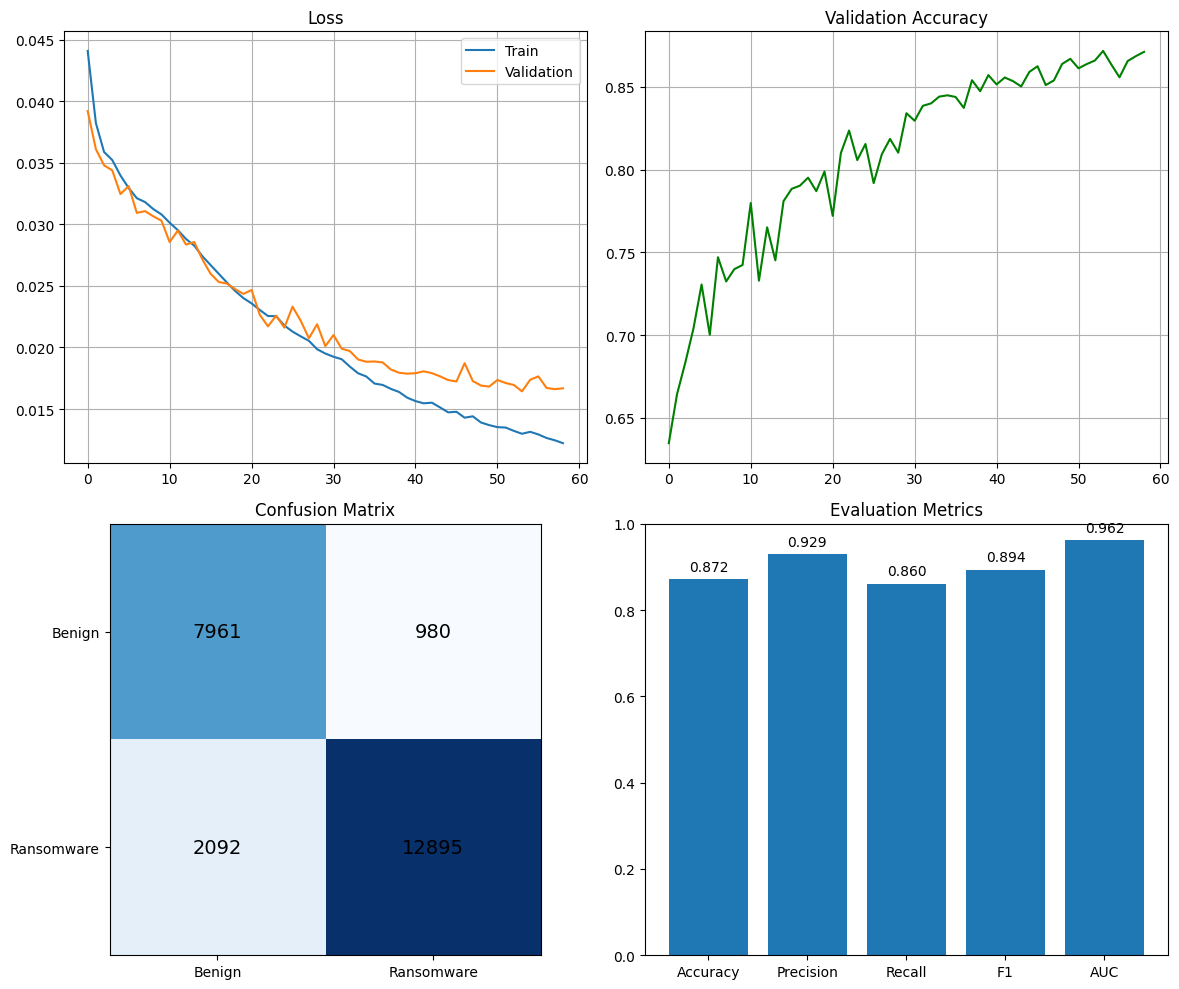

📊 Results saved to results.png

💾 Model saved to best_model.pth


In [32]:
def main():
    print("=" * 70)
    print("🔐 Ransomware Detection | RanSMAP 2024 | FAST VERSION")
    print("=" * 70)

    # Set random seed
    set_seed()

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_gpus = torch.cuda.device_count()
    print(f"\n🖥️ Device: {device}, GPUs: {num_gpus}")

    # 1. Load data
    print("\n[1/6] 📥 Loading data...")
    loader = FastDataLoader()
    sequences, labels = loader.load_dataset()

    if len(sequences) == 0:
        print("❌ No data loaded!")
        return None, None

    # 2. Train-test split
    print("\n[2/6] ✂️ Splitting data...")
    if len(set(labels)) < 2:
        print("⚠️ Single class detected – using random split")
        idx = np.random.permutation(len(sequences))
        split = int(0.8 * len(idx))

        train_seq = [sequences[i] for i in idx[:split]]
        test_seq = [sequences[i] for i in idx[split:]]
        train_lab = [labels[i] for i in idx[:split]]
        test_lab = [labels[i] for i in idx[split:]]
    else:
        train_seq, test_seq, train_lab, test_lab = train_test_split(
            sequences,
            labels,
            test_size=0.2,
            stratify=labels,
            random_state=Config.SEED
        )

    print(f"✔ Train samples: {len(train_seq)}, Test samples: {len(test_seq)}")

    # 3. Create datasets
    print("\n[3/6] 📦 Creating datasets...")
    train_ds = RansomwareDataset(
        train_seq, train_lab, fit_scaler=True
    )
    test_ds = RansomwareDataset(
        test_seq, test_lab, scaler=train_ds.scaler
    )

    # Weighted sampler for class imbalance
    if len(set(train_lab)) > 1:
        counts = np.bincount(train_lab)
        weights = 1.0 / counts
        sample_weights = [weights[l] for l in train_lab]
        sampler = WeightedRandomSampler(
            sample_weights, len(sample_weights)
        )
    else:
        sampler = None

    train_loader = DataLoader(
        train_ds,
        batch_size=Config.BATCH_SIZE,
        sampler=sampler,
        shuffle=(sampler is None),
        num_workers=4,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # 4. Model
    print("\n[4/6] 🧠 Initializing model...")
    model = RansomwareDetector()
    total_params = sum(p.numel() for p in model.parameters())
    print(f"✔ Model parameters: {total_params:,}")

    # 5. Training
    print("\n[5/6] 🚀 Training...")
    trainer = Trainer(model, device, num_gpus)
    train_results = trainer.train(train_loader, test_loader)

    # 6. Evaluation
    print("\n[6/6] 📊 Evaluating...")
    evaluator = Evaluator(trainer.model, device)
    eval_results = evaluator.evaluate(test_loader)

    print("\n" + "=" * 50)
    print("✅ RESULTS")
    print("=" * 50)
    print(f"Accuracy : {eval_results['accuracy']:.4f}")
    print(f"Precision: {eval_results['precision']:.4f}")
    print(f"Recall   : {eval_results['recall']:.4f}")
    print(f"F1-score : {eval_results['f1']:.4f}")
    print(f"AUC-ROC  : {eval_results['auc_roc']:.4f}")
    print("\n" + eval_results["report"])

    # Plot results
    evaluator.plot_results(train_results, eval_results)

    # Save model
    torch.save(
        {
            "model": trainer.model.state_dict(),
            "results": eval_results
        },
        "best_model.pth"
    )
    print("\n💾 Model saved to best_model.pth")

    return eval_results, train_results


if __name__ == "__main__":
    results, training = main()

In [36]:
import os
import time
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

# ============================================================
# 1. Configuration and Architecture
# (Copied from main.py for compatibility)
# ============================================================

class Config:
    INPUT_SIZE = 5
    HIDDEN_SIZE = 128
    NUM_LAYERS = 2
    NUM_CLASSES = 2
    DROPOUT = 0.3

    SEQUENCE_LENGTH = 128
    STRIDE = 64

    CLASSES = ["Benign (Legitimate)", "Ransomware (Malicious)"]

    # NEW: Inference batch size to avoid OutOfMemoryError
    INFERENCE_BATCH_SIZE = 64


# ============================================================
# Attention Layer
# ============================================================

class AttentionLayer(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        """
        x shape: (batch_size, sequence_length, hidden_size)
        """
        weights = F.softmax(self.attention(x), dim=1)
        attended = torch.sum(weights * x, dim=1)
        return attended, weights


# ============================================================
# Ransomware Detection Model
# ============================================================

class RansomwareDetector(nn.Module):
    def __init__(self):
        super().__init__()

        # Input projection layer
        self.input_proj = nn.Sequential(
            nn.Linear(Config.INPUT_SIZE, Config.HIDDEN_SIZE),
            nn.LayerNorm(Config.HIDDEN_SIZE),
            nn.ReLU(),
            nn.Dropout(Config.DROPOUT)
        )

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=Config.HIDDEN_SIZE,
            hidden_size=Config.HIDDEN_SIZE,
            num_layers=Config.NUM_LAYERS,
            batch_first=True,
            bidirectional=True,
            dropout=Config.DROPOUT if Config.NUM_LAYERS > 1 else 0
        )

        # Attention layer
        self.attention = AttentionLayer(Config.HIDDEN_SIZE * 2)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(Config.HIDDEN_SIZE * 2, Config.HIDDEN_SIZE),
            nn.LayerNorm(Config.HIDDEN_SIZE),
            nn.ReLU(),
            nn.Dropout(Config.DROPOUT),
            nn.Linear(Config.HIDDEN_SIZE, Config.NUM_CLASSES)
        )

    def forward(self, x):
        """
        Forward pass
        """
        x = self.input_proj(x)
        x, _ = self.lstm(x)
        x, attn_weights = self.attention(x)
        logits = self.classifier(x)
        return logits, attn_weights

In [37]:
# ============================================================
# 2. Auxiliary Dataset Class for Inference
# ============================================================

class SequenceInferenceDataset(torch.utils.data.Dataset):
    """
    Dataset for loading sequences during inference
    (used with DataLoader)
    """
    def __init__(self, data):
        # data: numpy array containing all sequences
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return tensor for the current sequence
        return torch.tensor(self.data[idx], dtype=torch.float32)


# ============================================================
# 3. Behavioral Analyzer
# ============================================================

class BehavioralAnalyzer:
    def __init__(self, model_path="best_model.pth", device=None):
        self.device = device if device else torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(f"🖥️ Using device: {self.device}")

        # Load model
        self.model = RansomwareDetector().to(self.device)
        self._load_weights(model_path)
        self.model.eval()

        # Scaler
        self.scaler = RobustScaler()

    def _load_weights(self, path):
        if not os.path.exists(path):
            raise FileNotFoundError(f"Model file not found: {path}")

        # Load checkpoint (weights_only for newer PyTorch versions)
        try:
            checkpoint = torch.load(
                path, map_location=self.device, weights_only=False
            )
        except Exception as e:
            print(f"❌ Critical error while loading model: {e}")
            print("⚠️ Ensure that best_model.pth was created by main.py")
            raise

        # Remove DataParallel prefix if present
        state_dict = checkpoint.get("model", checkpoint)
        new_state_dict = {}

        for k, v in state_dict.items():
            if k.startswith("module."):
                new_state_dict[k[7:]] = v
            else:
                new_state_dict[k] = v

        self.model.load_state_dict(new_state_dict)
        print(f"✅ Model weights loaded from {path} (DataParallel prefix removed)")

    def preprocess_file(self, csv_path):
        """
        Full preprocessing pipeline for a CSV file
        (identical to main.py)
        """
        try:
            df = pd.read_csv(
                csv_path,
                header=None,
                names=[
                    "timestamp", "timestamp_ns",
                    "address", "size",
                    "entropy", "flag"
                ]
            )
        except Exception as e:
            print(f"❌ Error reading CSV: {e}")
            return None, None

        # Extract features
        raw_data = df[
            ["timestamp", "timestamp_ns", "address", "size", "entropy"]
        ].values.astype(np.float32)

        # Feature transformations
        processed = raw_data.copy()
        processed[:, 0] -= processed[0, 0]          # Relative timestamp
        processed[:, 1] = np.log1p(processed[:, 1]) # Log timestamp_ns
        processed[:, 2] = np.log1p(processed[:, 2]) # Log address
        processed[:, 3] = np.log1p(processed[:, 3]) # Log size

        # Scaling (fit-transform for inference file)
        processed = self.scaler.fit_transform(processed)

        return df, processed

    def predict(self, csv_path):
        """
        Run inference on a single CSV file
        """
        # 1. Determine program name and type
        try:
            # Example path:
            # /PROGRAM_NAME/SESSION_ID/ata_write.csv
            session_dir = os.path.dirname(csv_path)
            program_dir = os.path.dirname(session_dir)
            program_name = os.path.basename(program_dir)

            if "_" in program_name:
                program_type = "Mixed"
            elif program_name.lower() in [
                "idle", "firefox", "diskcleanup", "delete"
            ]:
                program_type = "Benign"
            else:
                program_type = "Ransomware"

            program_info = f"{program_name} ({program_type})"
        except Exception:
            program_name = "Unknown-Program"
            program_info = "Unknown-Program"

        print(f"\n📁 File analysis: {os.path.basename(csv_path)}")
        print(f"🧪 Tested program: {program_info}")

        original_df, data = self.preprocess_file(csv_path)

        if data is None or len(data) < Config.SEQUENCE_LENGTH:
            print("⚠️ File too short or corrupted")
            return None

        # 2. Create sliding window sequences
        sequences = []
        indices = []

        for start in range(
            0,
            len(data) - Config.SEQUENCE_LENGTH + 1,
            Config.STRIDE
        ):
            seq = data[start:start + Config.SEQUENCE_LENGTH]
            sequences.append(seq)
            indices.append(start)

        if not sequences:
            return None

        sequences_array = np.array(sequences)

        # 3. DataLoader for efficient inference
        inference_dataset = SequenceInferenceDataset(sequences_array)
        inference_loader = torch.utils.data.DataLoader(
            inference_dataset,
            batch_size=Config.INFERENCE_BATCH_SIZE,
            shuffle=False,
            num_workers=0
        )

        all_probs = []
        all_preds = []
        all_attentions = []

        with torch.no_grad():
            for batch in inference_loader:
                batch = batch.to(self.device)
                logits, attentions = self.model(batch)
                probs = F.softmax(logits, dim=1)

                all_probs.append(probs.cpu().numpy())
                all_preds.append(torch.argmax(probs, dim=1).cpu().numpy())
                all_attentions.append(attentions.cpu().numpy())

        # 4. Collect results
        results = {
            "filename": os.path.basename(csv_path),
            "program_name": program_name,
            "total_sequences": len(sequences),
            "ransomware_prob": np.concatenate(all_probs)[:, 1],
            "predictions": np.concatenate(all_preds),
            "attentions": np.concatenate(all_attentions, axis=0),
            "indices": indices,
            "original_df": original_df
        }

        self._print_verdict(results)
        return results

    def _print_verdict(self, res):
        mean_prob = np.mean(res["ransomware_prob"])
        max_prob = np.max(res["ransomware_prob"])
        count_malicious = np.sum(res["predictions"])
        program_name = res.get("program_name", "Unknown")

        print("=" * 58)
        print(f"🔍 ANALYSIS RESULT: {program_name}")
        print("=" * 58)
        print(f"Total sequences analyzed: {res['total_sequences']}")
        print(f"Sequences flagged as malicious: {count_malicious}")
        print(f"Average ransomware probability: {mean_prob:.2f}")
        print(f"Maximum ransomware probability: {max_prob:.2f}")

        if mean_prob > 0.5:
            print("🚨 VERDICT: RANSOMWARE (MALICIOUS)")
            print(f"⚠️ Program '{program_name}' matches attack behavior patterns.")
        else:
            print("✅ VERDICT: BENIGN (LEGITIMATE)")
            print(f"✔️ Program '{program_name}' matches normal behavior.")
        print("=" * 58)

    def visualize(self, results, save_dir="analysis_output"):
        """
        Visualize inference results
        """
        os.makedirs(save_dir, exist_ok=True)

        df = results["original_df"]
        probs = results["ransomware_prob"]
        indices = results["indices"]

        plt.style.use("dark_background")
        fig = plt.figure(figsize=(16, 10))
        gs = fig.add_gridspec(3, 2)

        # 1. Ransomware probability over time
        ax1 = fig.add_subplot(gs[0, :])
        time_axis = [
            i + Config.SEQUENCE_LENGTH // 2 for i in indices
        ]
        color_line = ["#ff4d4d" if p > 0.5 else "#00ffae" for p in probs]
        ax1.scatter(time_axis, probs, c=color_line, alpha=0.8)
        ax1.plot(time_axis, probs, color="white", alpha=0.3)
        ax1.axhline(0.5, color="yellow", linestyle="--", label="Threshold")
        ax1.set_title(
            f"Ransomware Probability Over Time ({results['filename']})",
            fontsize=14
        )
        ax1.set_ylabel("Ransomware Probability")
        ax1.set_ylim(-0.1, 1.1)
        ax1.legend()

        # 2. Entropy (encryption indicator)
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.plot(df["entropy"], color="#ff9f1a", alpha=0.7)
        ax2.set_title("Write Operation Entropy")
        ax2.set_ylabel("Shannon Entropy")

        # 3. Write size (log scale)
        ax3 = fig.add_subplot(gs[1, 1])
        ax3.plot(np.log1p(df["size"]), color="#1abc9c", alpha=0.7)
        ax3.set_title("Write Size (Log Scale)")
        ax3.set_ylabel("Bytes (Log)")

        # 4. Attention analysis on most suspicious window
        max_risk_idx = np.argmax(probs)
        if probs[max_risk_idx] > 0.5:
            ax4 = fig.add_subplot(gs[2, :])
            window_attn = results["attentions"][max_risk_idx].flatten()
            start_row = indices[max_risk_idx]
            end_row = start_row + Config.SEQUENCE_LENGTH

            window_entropy = df["entropy"].iloc[start_row:end_row].values

            ax4.plot(window_attn * 100, color="red", alpha=0.6, label="Model Attention")
            ax4_twin = ax4.twinx()
            ax4_twin.plot(
                window_entropy, color="cyan", label="Entropy"
            )

            ax4.set_title(
                f"Model Attention vs Entropy (Suspicious Window #{max_risk_idx})"
            )
            ax4.set_xlabel("Time Step")
            ax4.set_ylabel("Model Attention (%)")
            ax4_twin.set_ylabel("Entropy")

            lines1, labels1 = ax4.get_legend_handles_labels()
            lines2, labels2 = ax4_twin.get_legend_handles_labels()
            ax4.legend(
                lines1 + lines2,
                labels1 + labels2,
                loc="upper left"
            )

        plt.tight_layout()
        save_path = os.path.join(
            save_dir, f"report_{results['filename']}.png"
        )
        plt.savefig(save_path, dpi=150)
        print(f"📊 Visual report saved to: {save_path}")
        plt.show()


🖥️ Using device: cuda
✅ Model weights loaded from best_model.pth (DataParallel prefix removed)

📁 File analysis: ata_write.csv
🧪 Tested program: Firefox_REvil (Mixed)
🔍 ANALYSIS RESULT: Firefox_REvil
Total sequences analyzed: 7941
Sequences flagged as malicious: 6571
Average ransomware probability: 0.74
Maximum ransomware probability: 1.00
🚨 VERDICT: RANSOMWARE (MALICIOUS)
⚠️ Program 'Firefox_REvil' matches attack behavior patterns.
📊 Visual report saved to: analysis_output/report_ata_write.csv.png


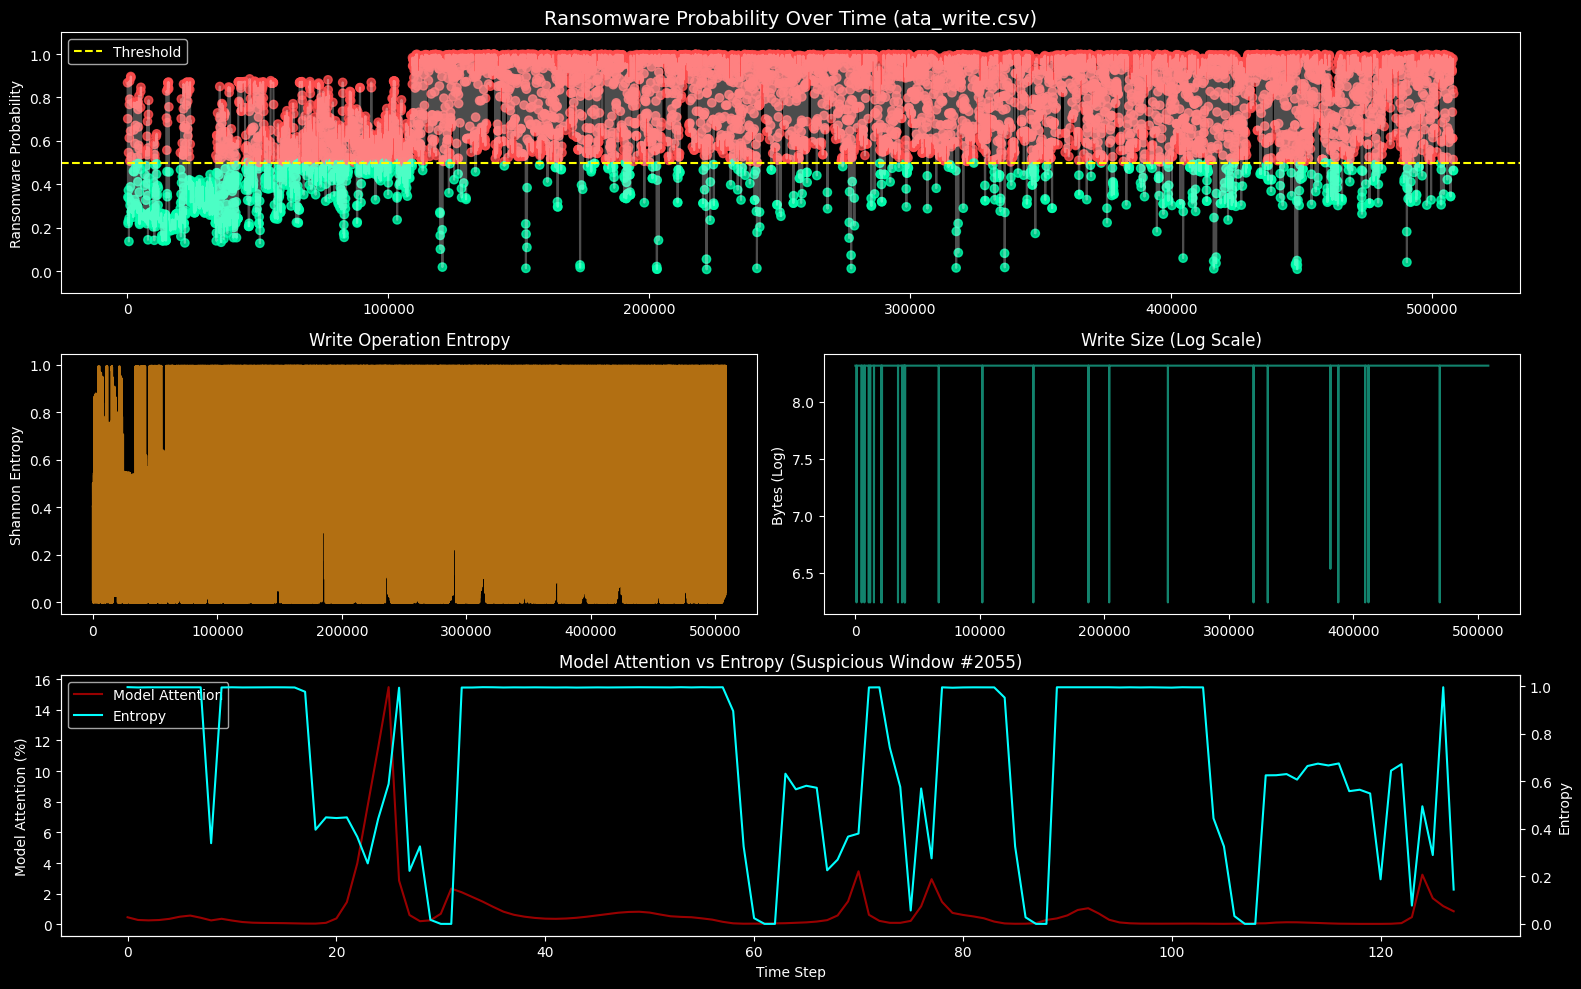


📁 File analysis: ata_write.csv
🧪 Tested program: Darkside (Ransomware)
🔍 ANALYSIS RESULT: Darkside
Total sequences analyzed: 5493
Sequences flagged as malicious: 2041
Average ransomware probability: 0.39
Maximum ransomware probability: 1.00
✅ VERDICT: BENIGN (LEGITIMATE)
✔️ Program 'Darkside' matches normal behavior.
📊 Visual report saved to: analysis_output/report_ata_write.csv.png


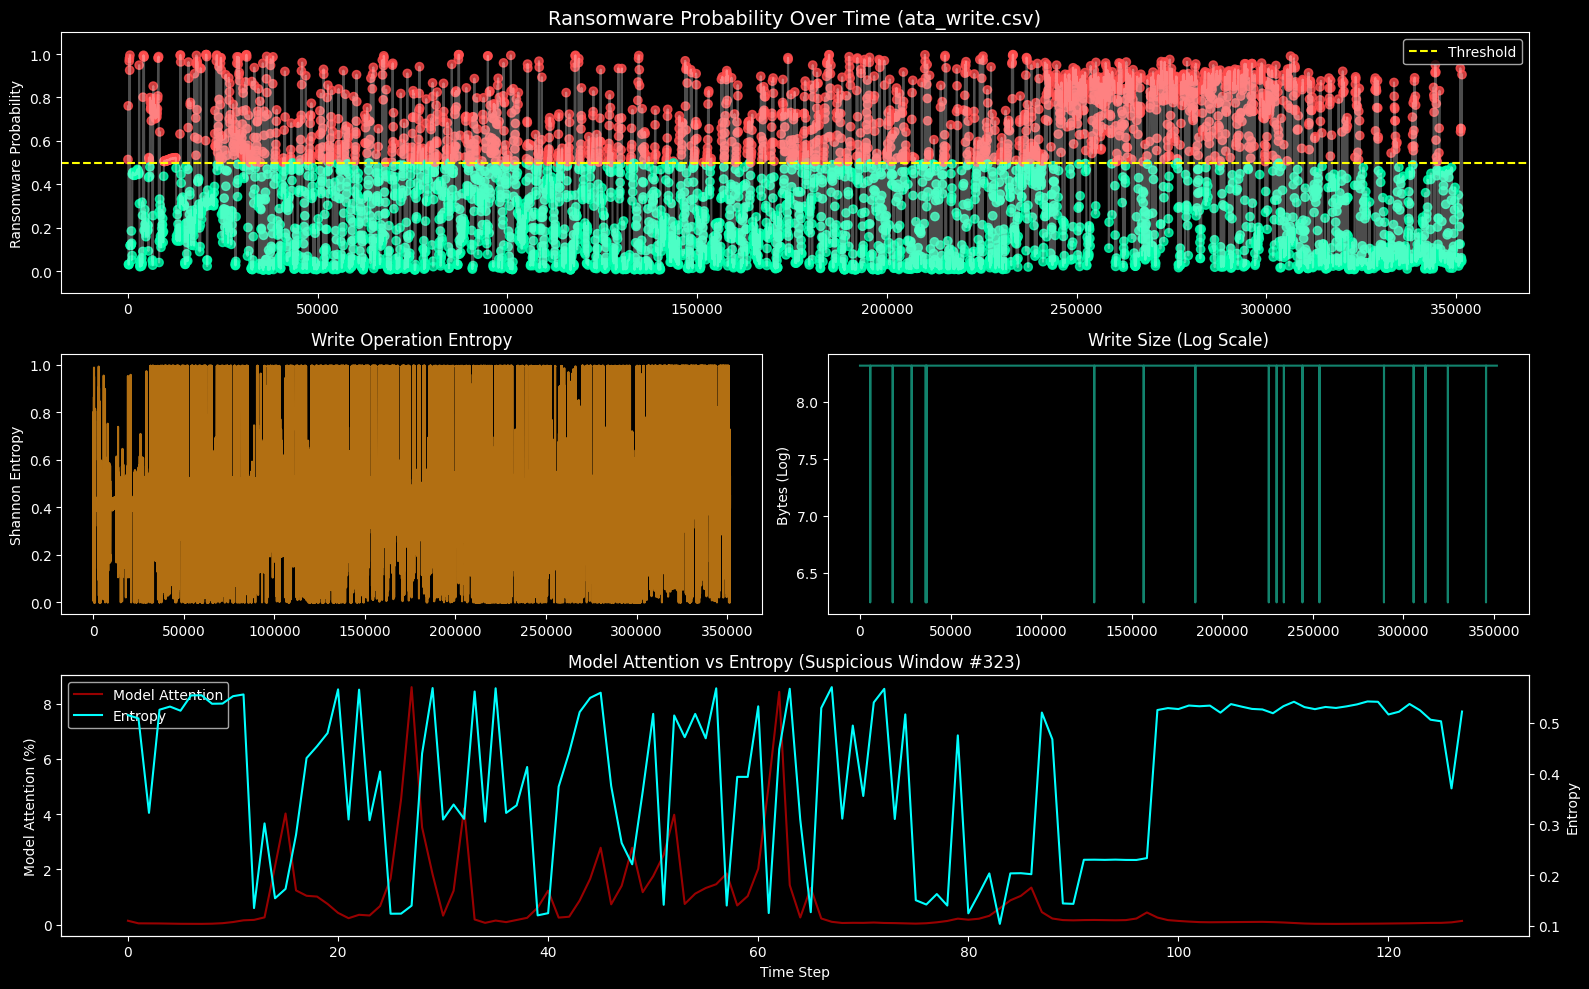


📁 File analysis: ata_write.csv
🧪 Tested program: REvil (Ransomware)
🔍 ANALYSIS RESULT: REvil
Total sequences analyzed: 1764
Sequences flagged as malicious: 1246
Average ransomware probability: 0.69
Maximum ransomware probability: 1.00
🚨 VERDICT: RANSOMWARE (MALICIOUS)
⚠️ Program 'REvil' matches attack behavior patterns.
📊 Visual report saved to: analysis_output/report_ata_write.csv.png


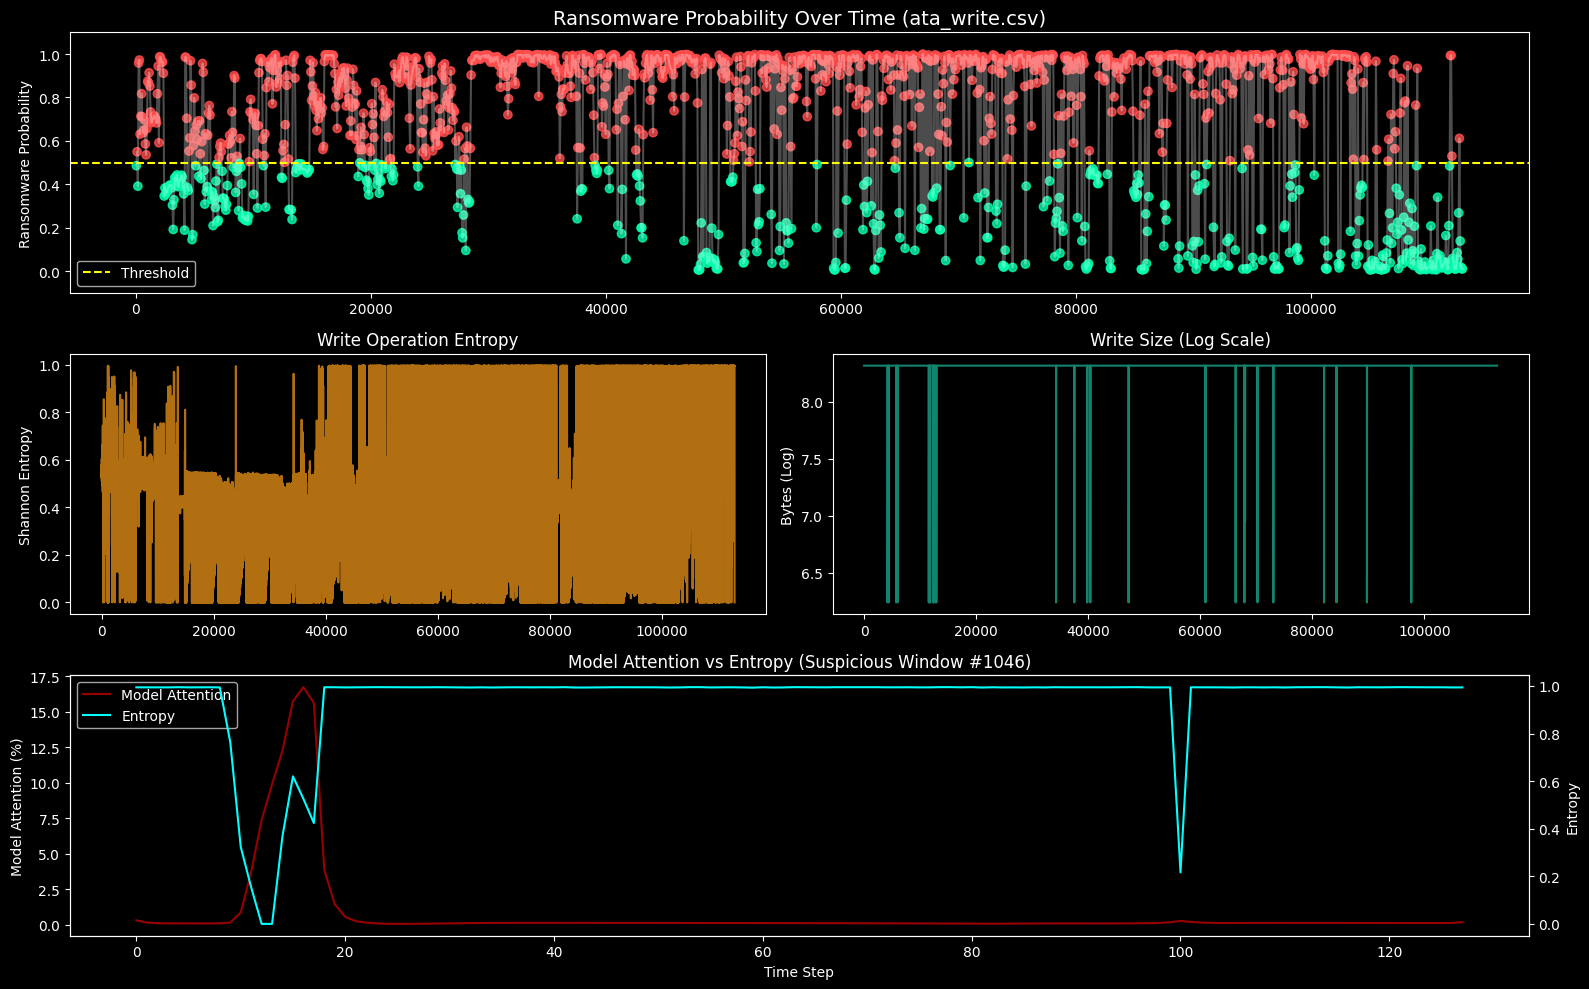


📁 File analysis: ata_write.csv
🧪 Tested program: SDelete (Ransomware)
🔍 ANALYSIS RESULT: SDelete
Total sequences analyzed: 37462
Sequences flagged as malicious: 17155
Average ransomware probability: 0.44
Maximum ransomware probability: 1.00
✅ VERDICT: BENIGN (LEGITIMATE)
✔️ Program 'SDelete' matches normal behavior.
📊 Visual report saved to: analysis_output/report_ata_write.csv.png


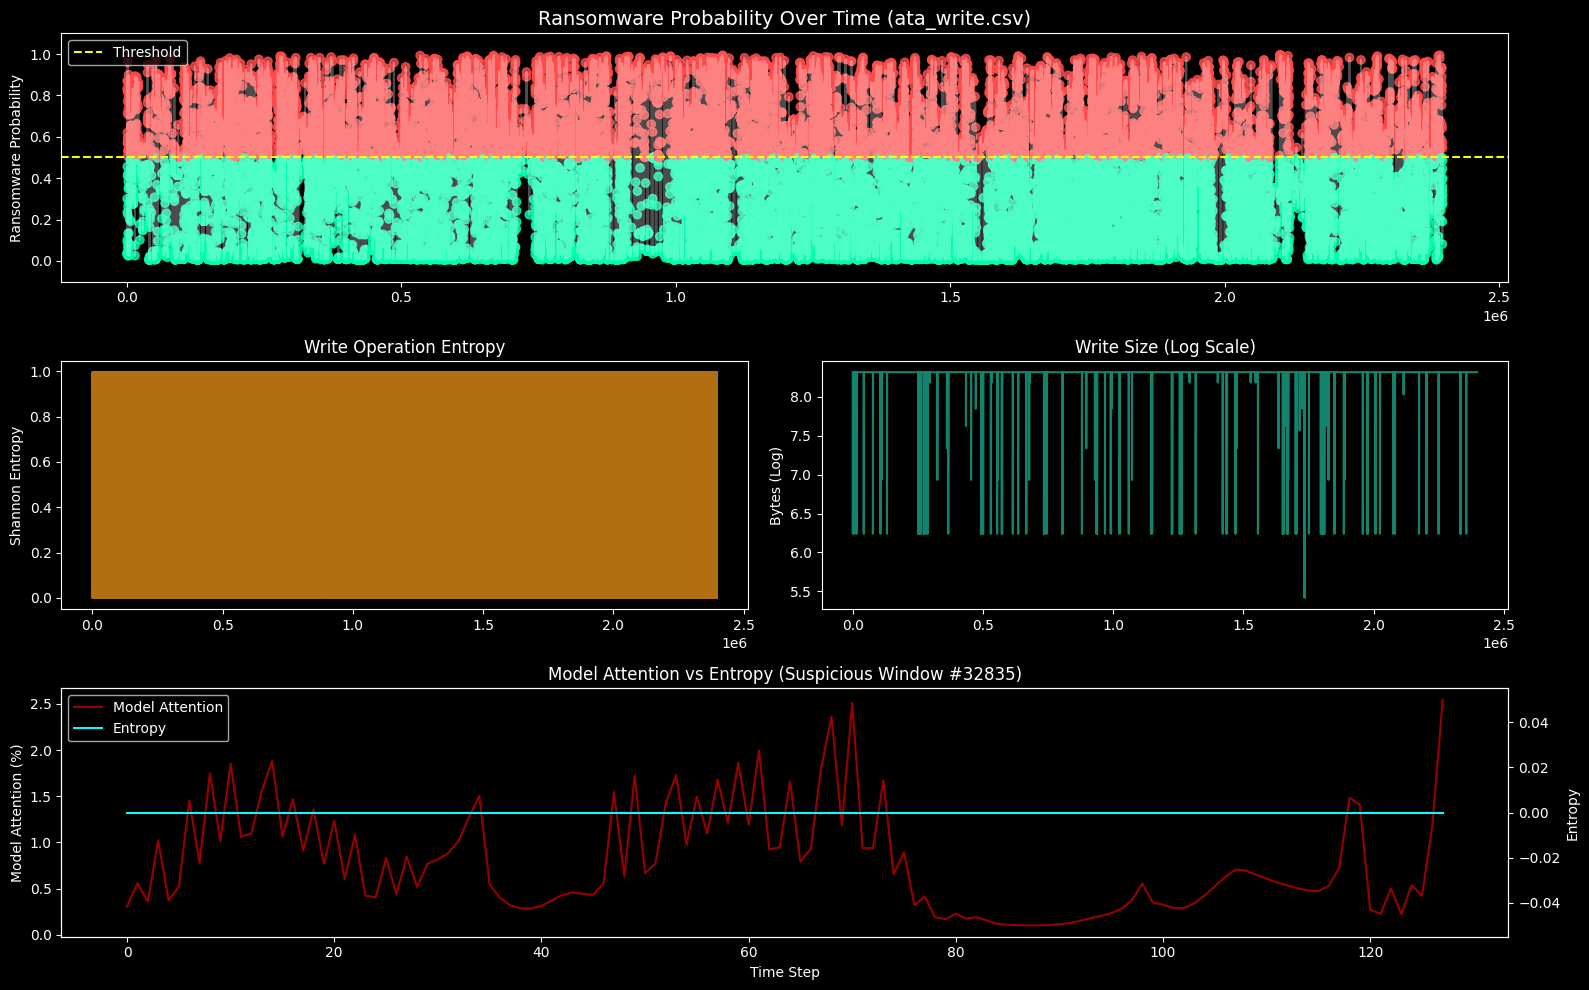

⚠️ File not found: /kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/original/celeron-gen6/ddr4-1600-8g/Idle/Idle-20230104_14-02-43/ata_write.csv

📁 File analysis: ata_write.csv
🧪 Tested program: Office (Ransomware)
🔍 ANALYSIS RESULT: Office
Total sequences analyzed: 195
Sequences flagged as malicious: 82
Average ransomware probability: 0.49
Maximum ransomware probability: 0.98
✅ VERDICT: BENIGN (LEGITIMATE)
✔️ Program 'Office' matches normal behavior.
📊 Visual report saved to: analysis_output/report_ata_write.csv.png


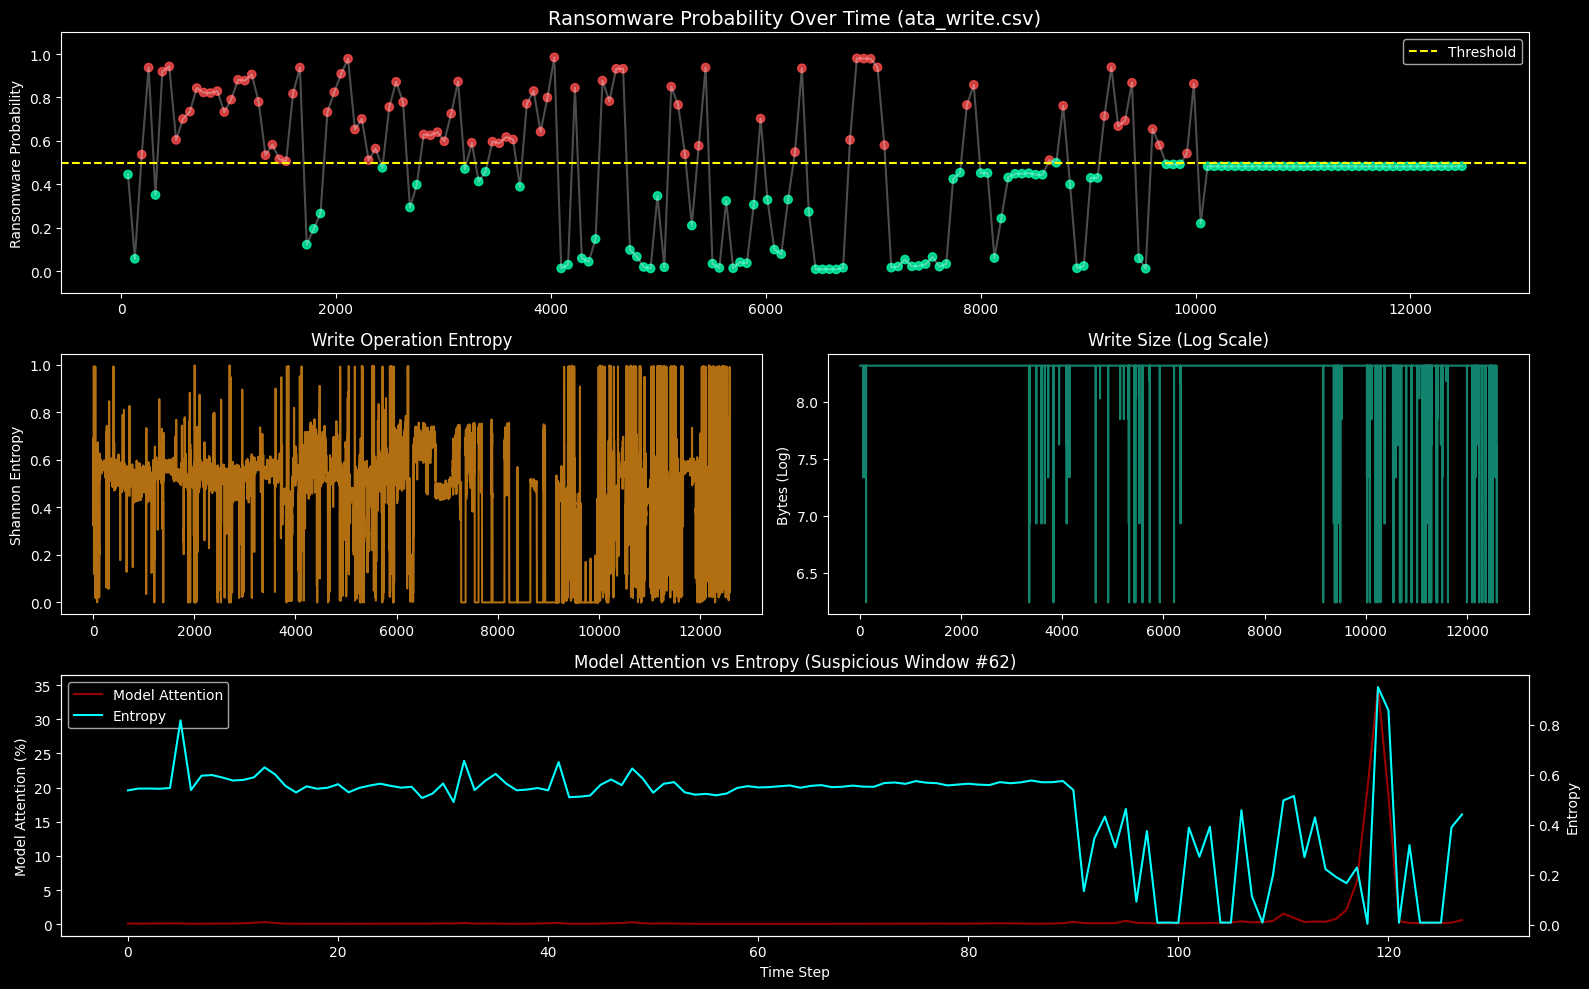


📁 File analysis: ata_read.csv
🧪 Tested program: Zip (Ransomware)
🔍 ANALYSIS RESULT: Zip
Total sequences analyzed: 11349
Sequences flagged as malicious: 7461
Average ransomware probability: 0.57
Maximum ransomware probability: 1.00
🚨 VERDICT: RANSOMWARE (MALICIOUS)
⚠️ Program 'Zip' matches attack behavior patterns.
📊 Visual report saved to: analysis_output/report_ata_read.csv.png


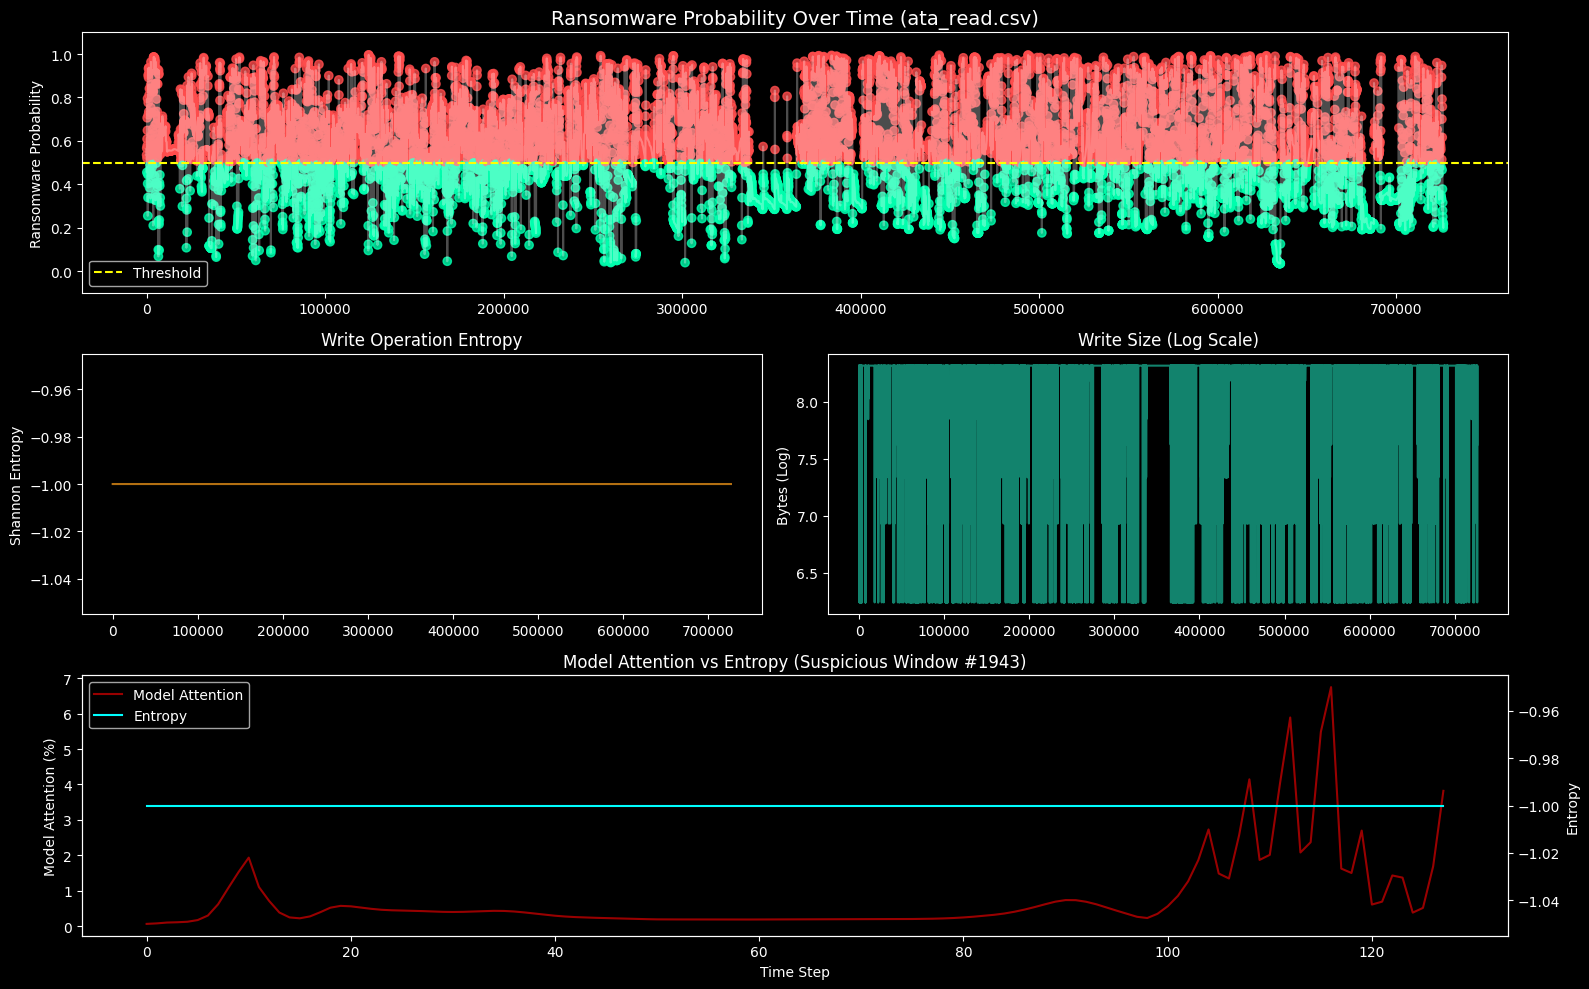


✅ Analysis of all test files completed.


In [38]:
# ============================================================
# 4. RUN
# ============================================================

if __name__ == "__main__":

    # 1. Create analyzer
    analyzer = BehavioralAnalyzer("best_model.pth")

    # 2. List of files to analyze (updated as per your request)
    test_files = [

        # === RANSOMWARE & MIXED SCENARIOS (Expected HIGH risk) ===

        # 1. Mixed scenario: Firefox infected with REvil (High risk)
        "/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/mix/i3-gen12/ddr4-2133-16g/Firefox_REvil/Firefox_REvil-20240305_00-40-39/ata_write.csv",

        # 2. Pure Darkside ransomware (High risk)
        "/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/original/celeron-gen6/ddr4-1866-16g/Darkside/Darkside-20221215_11-06-27/ata_write.csv",

        # 3. Pure REvil ransomware (High risk)
        "/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/original/i3-gen12/ddr4-2133-8g/REvil/REvil-20230628_20-47-19/ata_write.csv",

        # === BENIGN SCENARIOS (Expected LOW risk) ===

        # 4. Legitimate Delete utility (data deletion, not encryption)
        "/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/original/i3-gen12/ddr4-2666-16g/SDelete/SDelete-20230118_20-33-59/ata_write.csv",

        # 5. Idle system
        "/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/original/celeron-gen6/ddr4-1600-8g/Idle/Idle-20230104_14-02-43/ata_write.csv",

        # 6. Pure Firefox (normal I/O activity)
        "/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/original/i3-gen12/ddr4-2666-16g/Office/Office-20230118_22-38-29/ata_write.csv",

        # 7. System utility: Disk Cleanup
        "/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/original/i3-gen12/ddr4-2666-16g/Zip/Zip-20230117_22-29-41/ata_read.csv"
    ]

    # 3. Run analysis for each file
    for file_path in test_files:
        if os.path.exists(file_path):
            result = analyzer.predict(file_path)
            if result:
                analyzer.visualize(result)
        else:
            print(f"⚠️ File not found: {file_path}")

    print("\n✅ Analysis of all test files completed.")
